In [2]:
import picam_raw_analysis
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Raw vs JPEG encoding
First, we need to load an image.  This is done by the picam_raw_analysis module, which is extracted from the picamera_cra_compensation repository, in the [analysis folder]

[analysis folder]: https://gitlab.com/bath_open_instrumentation_group/picamera_cra_compensation/-/tree/master/analysis

In [3]:
fname = r"R:\RC-PH1201\Secret_Challenge_Data\SCAN_HQ7Q_THIN\HQ7Q_THIN_1155_411265_3178479.jpeg"

raw_image, jpeg, metadata = picam_raw_analysis.extract_raw_image.load_raw_image(fname, open_jpeg=True)

## Check that loded OK
Next, we plot (left) the raw Bayer data, (middle) the demosaiced but unprocessed data, and (right) the JPEG

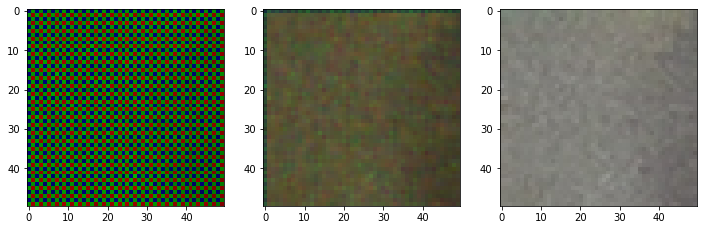

In [33]:
f, ax = plt.subplots(1,3, figsize=(12,4))

ax[0].imshow(raw_image.array[:50,:50,:])

demosaiced = raw_image.demosaic()
ax[1].imshow(demosaiced[:50,:50,:])

processed = np.array(jpeg)
ax[2].imshow(processed[:50,:50,:])

Note that the Bayer patterned image has only one non-zero channel per pixel, because that's how the sensor is laid out - the middle image has been smoothed to give an approximation to a colour image, and the right-hand one has been further smoothed and denoised when it was converted to JPEG.  The brightnesses will be very different, because there is not yet any colour balance or lens shading applied to the raw image.

Next, we load the settings, which will allow us to extract things like the lens shading table.

In [39]:
import json
settings = json.loads(metadata[37510])

The next cell loads the lens shading table from the metadata stored in the JPEG and turns it back into a ``numpy`` array.

Lens shading table has shape (4, 39, 52)


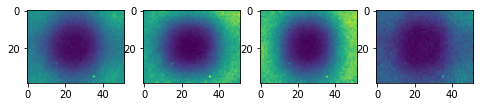

In [35]:
import base64

def lst_from_json(lst_info):
    """Reconstitute a numpy array from a base64 buffer"""
    lst_data = base64.decodebytes(lst_info["base64"].encode("UTF-8"))
    lst_array = np.frombuffer(lst_data, dtype=lst_info["dtype"])
    return lst_array.reshape(lst_info["shape"])

lst = lst_from_json(settings["instrument"]["settings"]["camera"]["picamera"]["lens_shading_table"])

f, axes = plt.subplots(1,4, figsize=(8,2))
for i, ax in enumerate(axes):
    ax.imshow(lst[i], vmin=32, vmax=np.max(lst))
print(f"Lens shading table has shape {lst.shape}")

We'll also need to extract the white balance and digital gain

In [41]:
white_balance = settings["instrument"]["settings"]["camera"]["picamera"]["awb_gains"]
digital_gain = settings["instrument"]["settings"]["camera"]["picamera"]["digital_gain"]

The lens shading table has two green elements (the first and last) because there are two green pixels in a Bayer pattern.  For now, let's average them together.  Also, the values are scaled such that 32 represents unity gain.  Finally, it's stored at 1/64 the resolution of the full image.  The cell below applies lens shading correction, white balance, and digital gain.

Array with size (39, 52) being zoomed by a factor of 64
Array with size (39, 52) being zoomed by a factor of 64
Array with size (39, 52) being zoomed by a factor of 64


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


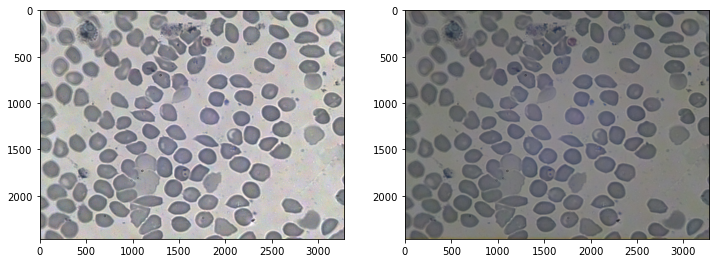

In [55]:
# The images are large, which broke the bilinear upsampling code in scipy :(
# The function below is very basic, but works rather faster!
from picam_raw_analysis.unmix_image import upsample_xy

def upsample_lst(lst):
    """Updample a lens shading table to full image resolution"""
    lst_r = lst[0,:,:]/32.0
    lst_g = lst[1,:,:]/64.0 + lst[2,:,:]/64.0
    lst_b = lst[3,:,:]/32.0
    return np.stack([upsample_xy(c, 64) for c in [lst_r, lst_g, lst_b]], axis=-1)

# 1. Lens shading correction
gains = upsample_lst(lst)
gains = gains[:demosaiced.shape[0], :demosaiced.shape[1], :]
            # crop gains so it's the right size (it may be slightly too big)
corrected_image = (demosaiced - 64.0)/255.0 * gains

# 2. White balance correction
corrected_image *= np.array([white_balance[0], 1.0, white_balance[1]])[np.newaxis, np.newaxis, :]

# 3. Digital gain
corrected_image *= digital_gain # I don't know if this is actually a good idea!

f, ax = plt.subplots(1,2, figsize=(12, 5))
ax[0].imshow(corrected_image)
ax[1].imshow(processed)

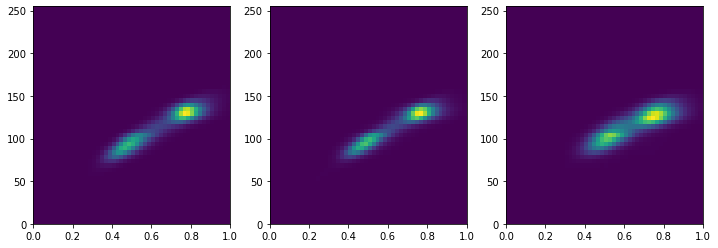

In [61]:
f, ax = plt.subplots(1,3, figsize=(12,4))

for i in range(3):
    x = corrected_image[:,:,i].flatten()
    y = processed[:,:,i].flatten()
    ax[i].hist2d(x, y,
                 range=[[0,1], [0,255]],
                 bins=50,
                )